# Setup and Configuration

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.patch_tst import PatchTSTForecaster
from sktime.datasets import load_longley
from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from datasetsforecast.long_horizon import LongHorizon

def scale_data(train, test):
    """Standardize data and ensure 2D format for the scaler."""
    if isinstance(train, pd.Series):
        train = train.to_frame()
        test = test.to_frame()
        
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train),
        index=train.index, columns=train.columns
    )
    test_scaled = pd.DataFrame(
        scaler.transform(test),
        index=test.index, columns=test.columns
    )
    return train_scaled, test_scaled, scaler

# PatchTST

In [7]:
def train_patchtst(y_train, x_train):
    """Train PatchTST using a configuration for layers and patching."""
    config = {
        "context_length": 4,       # Fit 12-point training set
        "prediction_length": 4,    # Matches forecast horizon (fh)
        "num_hidden_layers": 2,    # Reduced layers for tiny dataset
        "num_attention_heads": 2,
        "d_model": 16,
        "ffn_dim": 64,
        "dropout": 0.1,
        "patch_length": 2,         # Patches for small sequence
        "patch_stride": 1
    }
    
    # Training arguments are required for stable Trainer behavior
    training_args = {
        "num_train_epochs": 20,
        "output_dir": "patchtst_results",
        "logging_steps": 1
    }
    
    forecaster = PatchTSTForecaster(
        config=config,
        training_args=training_args
    )
        
    # Fit using target and exogenous covariates
    forecaster.fit(y=y_train, X=x_train, fh=np.arange(1, 5))
    return forecaster

# Load Longley economic dataset
y, X = load_longley()
y_train_scaled, _, scaler_y = scale_data(y[:-4], y[-4:])
X_train_scaled, X_test_scaled, _ = scale_data(X[:-4], X[-4:])

# Train and forecast
model_patch = train_patchtst(y_train_scaled, X_train_scaled)
y_pred_scaled = model_patch.predict(X=X_test_scaled)

2026/02/03 14:51:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/03 14:51:27 INFO mlflow.store.db.utils: Updating database tables
2026/02/03 14:51:27 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/03 14:51:27 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/02/03 14:51:27 INFO alembic.runtime.migration: Running 

  3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,1.922200
2,1.922100
3,1.922100
4,1.922000
5,1.921900
6,1.921900
7,1.921800
8,1.921800
9,1.921700
10,1.921700


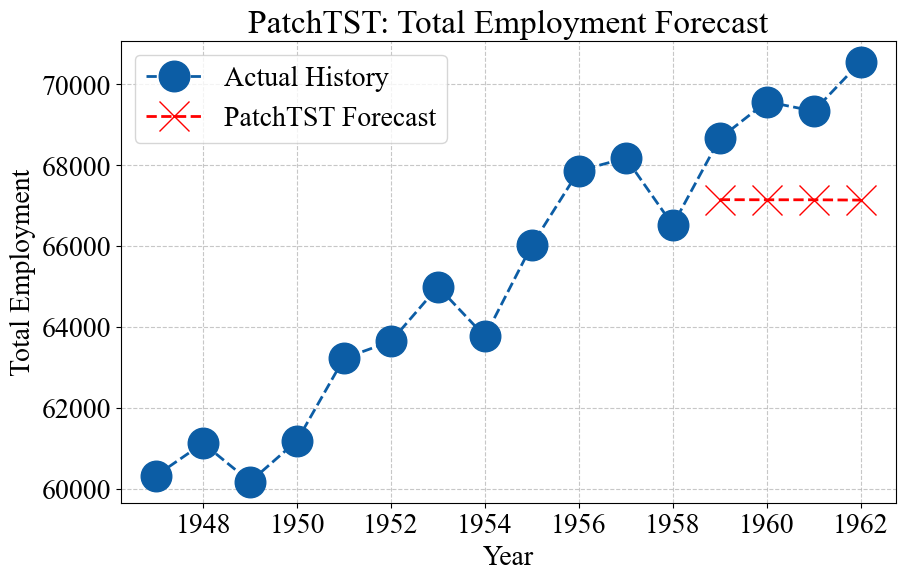

In [8]:
import matplotlib.pyplot as plt

# Inverse transform predictions to original scale
y_pred_unscaled = pd.DataFrame(
    scaler_y.inverse_transform(y_pred_scaled),
    index=y_pred_scaled.index,
    columns=y_pred_scaled.columns
)

def plot_patchtst_results(actual, forecast, title):
    """Plot original economic data against PatchTST predictions."""
    plt.figure(figsize=(10, 6))
    
    # Convert PeriodIndex to timestamp for matplotlib compatibility
    plt.plot(
        actual.index.to_timestamp(), 
        actual.values, 
        label="Actual History", 
        marker='o'
    )
    plt.plot(
        forecast.index.to_timestamp(), 
        forecast.values, 
        label="PatchTST Forecast", 
        color="red", 
        marker='x', 
        linewidth=2
    )
    
    plt.title(title)
    plt.ylabel("Total Employment")
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_patchtst_results(y, y_pred_unscaled, "PatchTST: Total Employment Forecast")

# iTransformer

In [16]:
def train_itransformer(train_df, num_series):
    """Train iTransformer using e_layers and d_layers per source signature."""
    model = iTransformer(
        h=96,
        input_size=336,
        n_series=num_series,
        hidden_size=64,
        n_heads=4,
        e_layers=2,
        d_layers=1,
        random_seed=42,
        max_steps=10,      # Limits training to 10 batches
    )
    
    nf = NeuralForecast(models=[model], freq='h') # 'h' for hourly
    nf.fit(df=train_df)
    return nf

In [17]:
# Load data using the correct 'TrafficL' group
Y_df, _, _ = LongHorizon.load(directory='./data', group='TrafficL')

# Temporal split: Reserve last 96 hours for validation
# Convert ds to datetime to allow temporal arithmetic
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
last_ts = Y_df['ds'].max()
split_point = last_ts - pd.Timedelta(hours=96)
train_df = Y_df[Y_df.ds <= split_point]

# Train model
num_series = train_df['unique_id'].nunique()
nf_itrans = train_itransformer(train_df, num_series)

Seed set to 42
/Users/ben/anaconda3/envs/ml_timeseries/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 21.6 K | train
4 | encoder       | TransEncoder           | 562 K  | train
5 | projector     | Linear                 | 6.2 K  | train
-----------------------------------------------------------------
590 K     Trainable params
0         Non-trainable params
590 K     Total params
2.361     Total es

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=10` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

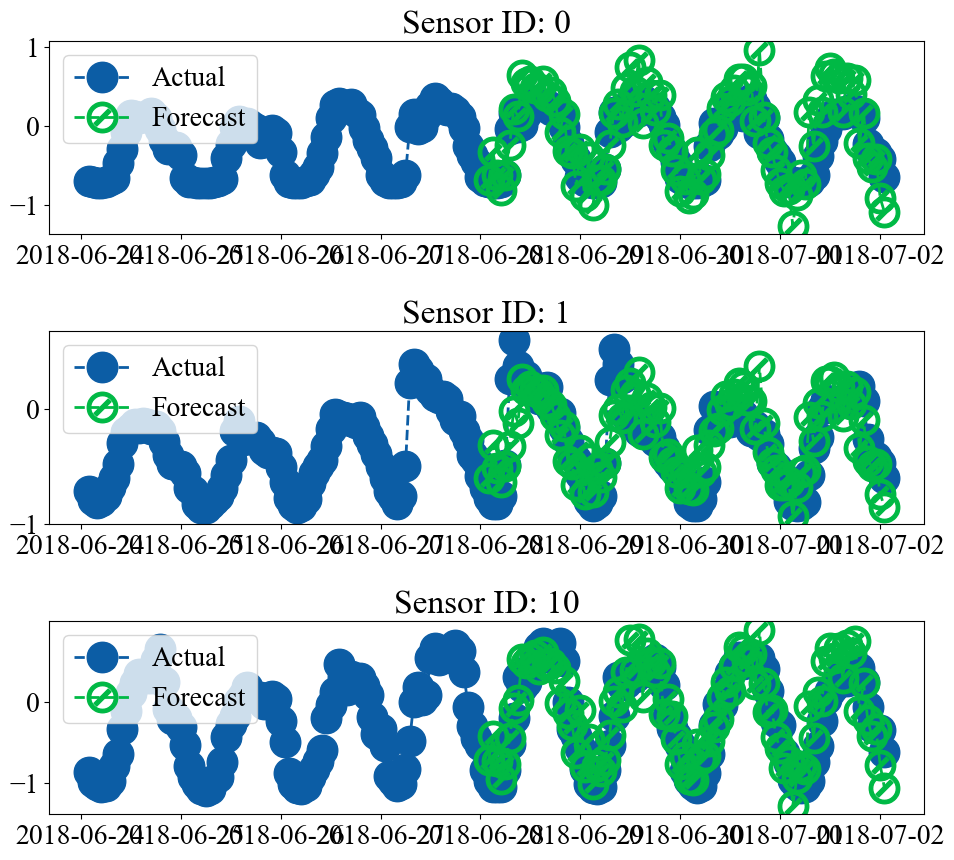

In [18]:
import matplotlib.pyplot as plt

# Forecasts will return a DataFrame with 'unique_id', 'ds', and 'iTransformer'
forecasts = nf_itrans.predict()

# Visualize subset of results
def plot_itransformer_results(df_actual, df_forecast, ids_to_plot):
    """Plot actual vs forecast for selected traffic sensors."""
    num_plots = len(ids_to_plot)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))
    
    for i, uid in enumerate(ids_to_plot):
        actual = df_actual[df_actual.unique_id == uid].tail(192) # 96h + 96h context
        forecast = df_forecast[df_forecast.unique_id == uid]
        
        ax = axes[i] if num_plots > 1 else axes
        ax.plot(actual['ds'], actual['y'], label='Actual')
        ax.plot(forecast['ds'], forecast['iTransformer'], label='Forecast', ls='--')
        ax.set_title(f"Sensor ID: {uid}")
        ax.legend()
        
    plt.tight_layout()
    plt.show()

# Visualize the first 3 traffic sensors
selected_sensors = Y_df['unique_id'].unique()[:3]
plot_itransformer_results(Y_df, forecasts, selected_sensors)